In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import random as rn
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.python.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.applications.mobilenet import MobileNet

from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, save_img
from tensorflow.python.keras.layers import Dense, Flatten,MaxPooling2D, GlobalAveragePooling2D,BatchNormalization,Dropout,Conv2D,MaxPool2D
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from keras.utils.vis_utils import plot_model

In [ ]:
train_data_dir='drive/My Drive/Colab Notebooks/skincancer/train'
test_data_dir='drive/My Drive/Colab Notebooks/skincancer/test'

img_height= 224
img_width = 224
batch_size= 64




train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.1,
    validation_split=0.1) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    ) # set as validation data

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_height,img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 2374 images belonging to 2 classes.
Found 263 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


(224, 224, 3)


<function matplotlib.pyplot.show>

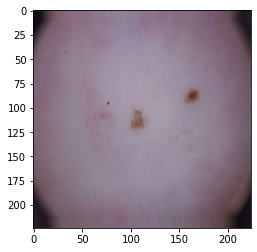

In [ ]:
x,y=next(train_generator)
print(x[0].shape)
plt.imshow(x[0,:,:,:])
plt.show

In [ ]:
epochs= 1
model = Sequential()

pretrained_model= InceptionV3(include_top=True,
                   input_shape=(224,224,3),
                   pooling=None,classes=2,
                   weights=None)
print(len(pretrained_model.layers))
# if we want to set the first  layers of the network to be non-trainable
#for layer in pretrained_model.layers[:len(pretrained_model.layers)-2]:
   # layer.trainable=False
#for layer in pretrained_model.layers[len(pretrained_model.layers)-2:]:
    #layer.trainable=True
#But train Batch Normalization layers
for layer in pretrained_model.layers:
    if(isinstance(layer,tf.keras.layers.BatchNormalization)):
        layer.trainable=True

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
red_lr= ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.7)
early_bird= EarlyStopping(monitor='accuracy', patience=10)
checkpoint= ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,mode='min',save_weights_only=False,save_best_only=True)

History = model.fit_generator(     train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[early_bird,checkpoint, red_lr])

313
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2)                 21806882  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_190 (Bat (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)          

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37/37 [==============================] - 1118s 30s/step - loss: 0.8284 - accuracy: 0.5535 - val_loss: 0.6921 - val_accuracy: 0.5469

Epoch 00001: val_loss improved from inf to 0.69211, saving model to model.hdf5


In [ ]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model.load_weights('model.hdf5')

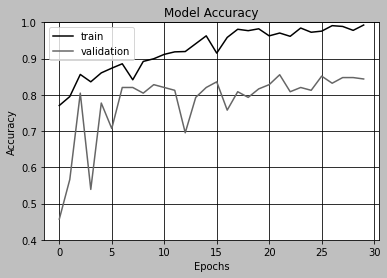

In [ ]:
plt.style.use('grayscale')
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis( ymin= 0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()



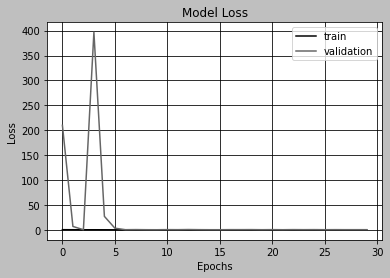

In [ ]:
fig1 = plt.gcf()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['train', 'validation'])
plt.show()
fig1.savefig('loss_plot.jpg')

In [ ]:
Y_pred = model.predict(test_generator)
y_pred=[]
for i in range(len(Y_pred)):
    if Y_pred[i][0]>0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print('Confusion Matrix')
print(metrics.confusion_matrix(test_generator.classes, y_pred))
print ()

print('Classification Report')
target_names = ['Non nevus', 'Nevus']
print(metrics.classification_report(test_generator.classes, y_pred, target_names=target_names))

print(test_generator.class_indices)

Confusion Matrix
[[304  56]
 [ 31 269]]

Classification Report
              precision    recall  f1-score   support

   Non nevus       0.91      0.84      0.87       360
       Nevus       0.83      0.90      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660

{'benign': 0, 'malignant': 1}
